**COMPUTE ANGULAR POWER SPECTRA $C_\ell$ FOR QUAIA**

* Use my own functions to compute the linear least-squares fit of the Quaia overdensities to $Y_{\ell m}$ templates, up to some max $\ell$, where the overdensity is defined as
$$
\delta_{g,p} = \frac{N_p}{(\sum_p N_p\,/ \sum_p w_p)}
$$
where $N_p$ and $w_p$ are the number of quasars and completeness in healpixel $p$. The denominator is the mean density of the _expected_ map.


* Reconstruct the map from the best-fit model (the best-fit spherical harmonic amplitudes $a_{\ell m}$ up to some max $\ell$: does this look crazy?


* Compare $C_\ell$ from my own functions to $C_\ell$ as output by `hp.anafast()`! Do they match?


* Compare these $C_\ell$ to the $C_\ell$ results from Giulio

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
import fitsio
from astropy.coordinates import SkyCoord
import astropy.units as u
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
from Secrest_dipole import SecrestDipole
from multipoles import construct_templates, compute_Cells_from_map, compute_Cells
import dipole
from jackknife import get_longitude_subsamples, compute_jackknife_uncertainty

### load sample

In [3]:
# load astropy Table and convert into healpix map

NSIDE = 64  # healpix resolution

# instantiate a dipole object and load the source density table - NOT corrected by the selection function
quaia_kwargs = dict(initial_catfn='quaia_G20.0.fits', catname='quaia', mag='G',
                    blim=30, maglim=20., save_tag='_r1.0', load_init=True, compcorrect=False)
d = SecrestDipole(**quaia_kwargs)
t = d.table

# construct map from source density table
datamap = tools.load_catalog_as_map(t, NSIDE=NSIDE)
mean, std = np.nanmean(datamap), np.nanstd(datamap)

loading initial catalog, quaia_G20.0.fits
755850 sources in initial catalog.


In [4]:
# delete tables - lots of memory!!
del d.table
del d.initial_cattab

In [5]:
# load selection function
selfunc = d.load_selfunc()

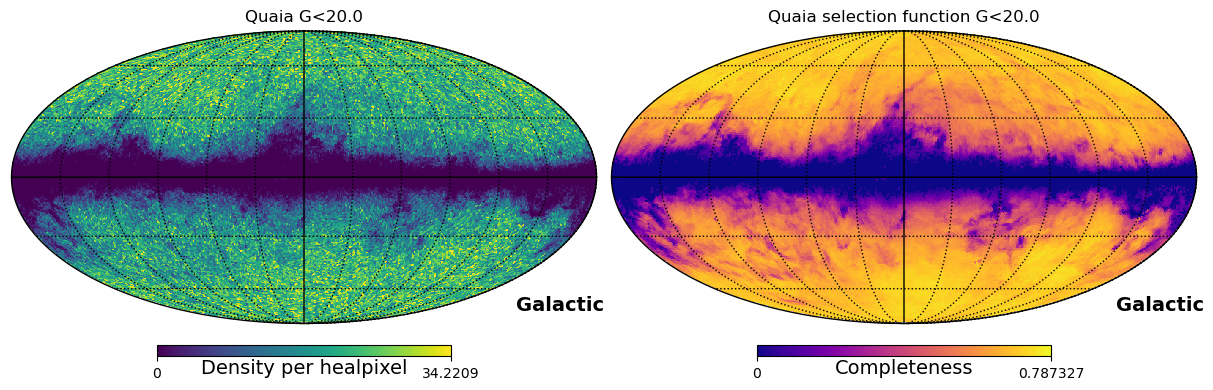

In [6]:
# plot these two
fig = plt.figure(figsize=(12,4))
kwargs = dict(fig=fig, coord=['C','G'], badcolor='white')
hp.mollview(datamap, title=f'Quaia G<{d.maglim}', sub=(1,2,1), unit='Density per healpixel',
            min=max(mean-2*std,0), max=mean+2*std, **kwargs)
hp.mollview(selfunc, title=f'Quaia selection function G<{d.maglim}', sub=(1,2,2), unit='Completeness',
            cmap='plasma', **kwargs)
hp.graticule()

In [7]:
# mask the data: galactic plane and smaller masks

# mask the galactic plane (mask pixels based on their central sky coordinate)
lon, lat = hp.pix2ang(NSIDE, np.arange(hp.nside2npix(NSIDE)), lonlat=True)
b = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').galactic.b
gal_plane_mask = np.zeros_like(datamap)
gal_plane_mask[np.abs(b.deg) >= d.blim] = 1

# load smaller masks (used in S21): at the pixel level
small_masks = fitsio.read(d.mask_fn)
assert len(small_masks) == len(gal_plane_mask) == hp.nside2npix(NSIDE)

# combine these two into a single mask
mask = gal_plane_mask.astype(bool) & small_masks.astype(bool)

# mask the data: populate a nan map with the data values in unmasked pixels
masked_datamap = np.multiply(datamap, mask, where=(mask!=0), out=np.full_like(datamap, np.nan))

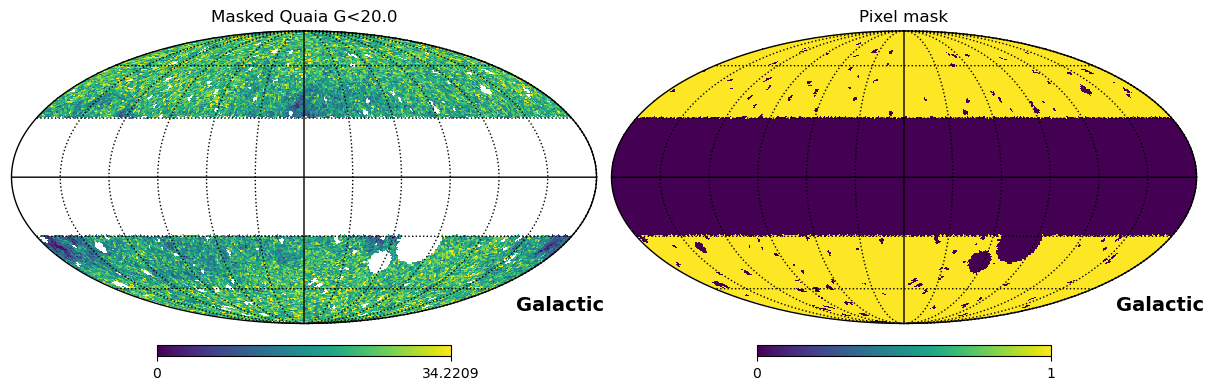

In [8]:
# plot the masked data map and the pixel mask
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], badcolor='w', fig=fig)
hp.mollview(masked_datamap, title=f'Masked Quaia G<{d.maglim}', min=max(mean-2*std,0), max=mean+2*std,
            sub=(1,2,1), **kwargs)
hp.mollview(mask, title='Pixel mask', sub=(1,2,2), **kwargs)
hp.graticule()

In [9]:
# covariances for the fit: the selection function
Cinv = selfunc

In [10]:
# GET OVERDENSITIES

# mean density of the map = sum((masked_datamap / selfunc) * Cinv) / sum(Cinv)
#  but in this case Cinv = selfunc, so
mean_density = np.nansum(masked_datamap) / np.nansum(selfunc)

# !! confused about the above, so for now I'm using
mean_density = np.nanmean(masked_datamap[selfunc>0] / selfunc[selfunc>0])

# then the overdensity map is
overdensity_map = np.divide(masked_datamap, selfunc, where=(selfunc>0),
                            out=np.full_like(masked_datamap, np.nan)) / mean_density - 1

In [11]:
mean_density

33.64255039156966

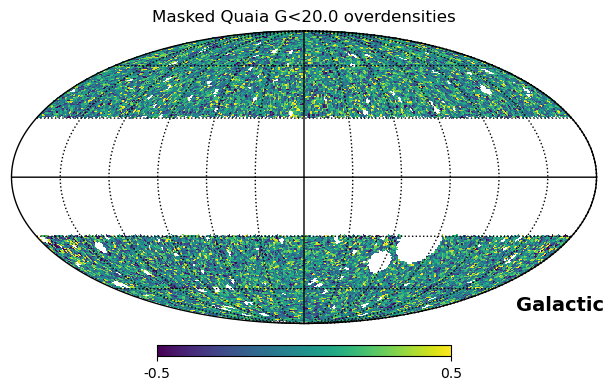

In [12]:
# plot the overdensity map
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], badcolor='w', fig=fig)
hp.mollview(overdensity_map, title=f'Masked Quaia G<{d.maglim} overdensities',
            min=-.5, max=.5, sub=(1,2,1), **kwargs)
hp.graticule()

In [13]:
np.nanmedian(np.abs(overdensity_map))

0.14870866345704814

In [14]:
np.nanmedian(overdensity_map)

-0.008284247097810504

In [15]:
# are we symmetric about zero?
np.nanmean(overdensity_map)

-1.5102690051864262e-16

### FIT $a_{\ell m}$, excluding masked pixels from the fit

In [16]:
# get the best-fit spherical harmonic amplitudes (alms) for the masked overdensity map, for several max ells

# pick a few max ells
max_ells = np.arange(1,9)

# empty lists to store results
ellss = []
almss = []
templatess = []

# indices to fit: non-NaN and non-zero, and where completeness > 0.5
idx_to_fit = (overdensity_map!=0.) & (~np.isnan(overdensity_map)) & (selfunc > 0.5)

for i, max_ell in enumerate(max_ells):
    print(max_ell)
    # construct Ylm templates
    ells = np.arange(0, max_ell+1)
    ellss.append(ells)
    templates = construct_templates(ells, NSIDE=NSIDE)
    # add the templates for this multipole
    templatess.append(templates)
    
    # design matrix: just the templates
    A = templates.T
    
    # indices to fit
    map_to_fit, A_fit, Cinv_fit = overdensity_map[idx_to_fit], A[idx_to_fit], Cinv[idx_to_fit]
    
    # perform the regression: bestfit_pars are the alms
    bestfit_pars, bestfit_Cinv = tools.lstsq(map_to_fit, A_fit, Cinv_fit)
    
    # add the alms for this multipole
    almss.append(bestfit_pars)

1
2
3
4
5
6
7
8


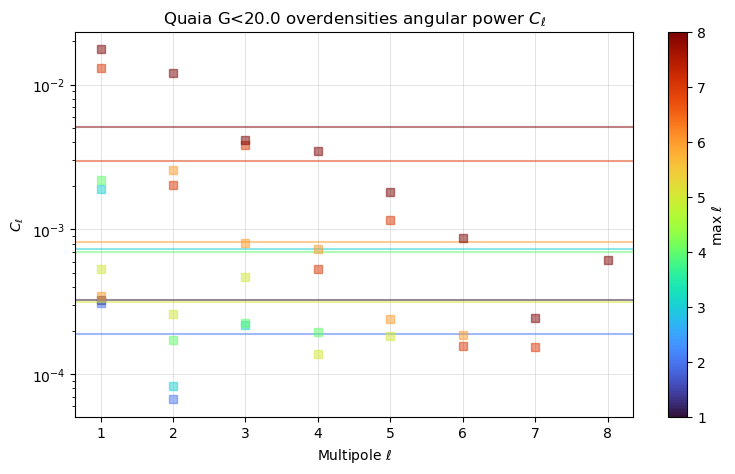

In [17]:
# calculate the Cells for each max_ell and plot the results

norm = mpl.colors.Normalize(vmin=min(max_ells), vmax=max(max_ells))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo')

fig, ax = plt.subplots(figsize=(9,5))
kwargs = dict(ls='None', alpha=0.5, marker='s')
for i, max_ell in enumerate(max_ells):
    # calculate the Cells for this max_ell
    Cells = compute_Cells(almss[i])
    # also calculate the mean power on these scales (excluding the monopole)
    mean_Cell = np.nanmean(Cells[1:])
    ax.plot(ellss[i][1:], Cells[1:], c=smap.to_rgba(max_ell), **kwargs)
    ax.axhline(mean_Cell, c=smap.to_rgba(max_ell), alpha=0.5)
ax.grid(alpha=0.5, lw=0.5)
ax.semilogy()
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$C_\ell$')
ax.set_title(r'Quaia G<'f'{d.maglim}'r' overdensities angular power $C_\ell$')
fig.colorbar(smap, ax=ax, label=r'max $\ell$')

### reconstruct the map
Our best-fit model of the map, given a fit to $\ell_\textrm{max}$, is
$$
f(\theta,\phi) = \sum_{\ell=0}^{\ell_\textrm{max}}\sum_{m=-\ell}^\ell\,a_{\ell m}Y_{\ell m}(\theta,\phi)
$$

In [18]:
# choose a max ell and make sure we have the expected number of alms
max_ell = 8
iell = np.where(max_ells==max_ell)[0][0]
assert len(almss[iell]) == np.sum([2*ell+1 for ell in np.arange(max_ell+1)])

In [19]:
# iterative over ells to correctly assign the alms to their respective multipoles
reconstructed_map = np.zeros_like(overdensity_map)
ell = 0
i1 = 0  # this will give us the starting index to pull from amps for each ell
while i1 < len(almss[iell]):
    i2 = i1 + 2 * ell + 1  # stopping index to pull from amps
    assert i2 <= len(almss[iell])  # make sure we aren't trying to pull more amplitudes than we input!
    # add the map for this ell to the overall reconstructed map
    map_thisell = np.zeros_like(overdensity_map)
    for im, alm_ in enumerate(almss[iell][i1:i2]):
        map_thisell += alm_ * templatess[iell][i1:i2][im]
    reconstructed_map += map_thisell
    ell += 1
    i1 = i2

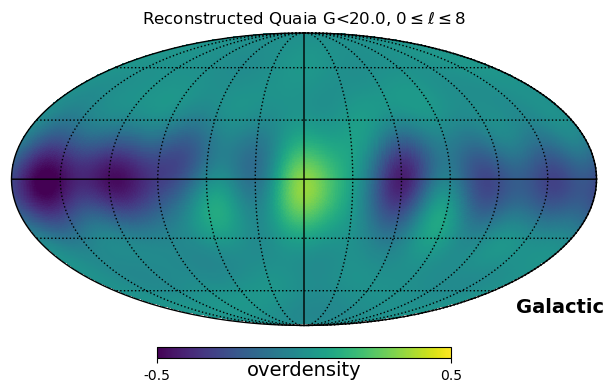

In [20]:
# plot the best-fit model for this max_ell
fig = plt.figure(figsize=(12,4))
hp.mollview(reconstructed_map, coord=['C','G'], unit='overdensity', min=-.5, max=.5, sub=(1,2,1), fig=fig,
            title=f'Reconstructed Quaia G<{d.maglim}, $0\leq\ell\leq$'f'{max_ell}')
hp.graticule()

Okay calamity in the masked region...
(but not as bad as when we were correcting the counts with the selection function incorrectly!)

### compare to `healpy.anafast()`

* `hp.anafast()` doesn't include the option to weight pixels in the fit (from what I can tell), so let's compare to my least-squares fit in the case that all pixels are equally weighted (`Cinv==identity`)
* this function sets any masked (`hp.UNSEEN`) pixels to zero and includes them in the fit!

In [21]:
# turn pixels except those to fit into hp.UNSEEN and compute Cells from hp.anafast()

# indices to fit: non-NaN and non-zero, and where completeness > 0.5
idx_to_fit = (overdensity_map!=0.) & (~np.isnan(overdensity_map)) & (selfunc > 0.5)
datamap_UNSEEN = np.copy(overdensity_map)
datamap_UNSEEN[~idx_to_fit] = hp.UNSEEN

# for a range of max ells
Cells_hps = [
    hp.anafast(datamap_UNSEEN, lmax=max_ell) for max_ell in max_ells
]

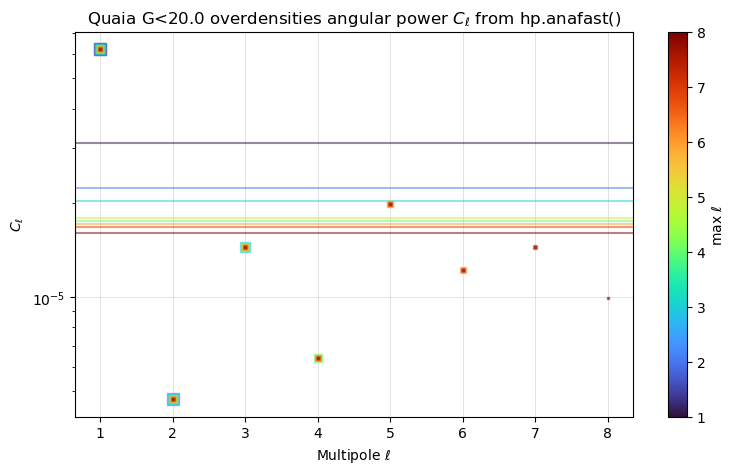

In [22]:
# plot the results; color by max ell

norm = mpl.colors.Normalize(vmin=min(max_ells), vmax=max(max_ells))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo')

fig, ax = plt.subplots(figsize=(9,5))
kwargs = dict(ls='None', alpha=0.5, marker='s')
for i, max_ell in enumerate(max_ells):
    # also calculate the mean power on these scales (excluding the monopole)
    mean_Cell = np.nanmean(Cells_hps[i])
    ax.plot(ellss[i][1:], Cells_hps[i][1:], c=smap.to_rgba(max_ell), ms=10-max_ell, **kwargs)
    ax.axhline(mean_Cell, c=smap.to_rgba(max_ell), alpha=0.5)
ax.grid(alpha=0.5, lw=0.5)
ax.semilogy()
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$C_\ell$')
ax.set_title(r'Quaia G<'f'{d.maglim}'r' overdensities angular power $C_\ell$ from hp.anafast()')
fig.colorbar(smap, ax=ax, label=r'max $\ell$')

### compare fits!

In [23]:
# choose a max ell
max_ell = 8

In [24]:
# hp.anafast()
Cells_hp = hp.anafast(datamap_UNSEEN, lmax=max_ell)

In [25]:
# my fit: try weighting pixels by completeness, and weighting equally

# construct Ylm templates
ells = np.arange(0, max_ell+1)
templates = construct_templates(ells, NSIDE=NSIDE)

# design matrix: just the templates
A = templates.T

# ** equally weight all pixels
Cinv_identity = np.ones_like(Cinv)
# indices to fit
map_to_fit, A_fit, Cinv_fit = overdensity_map[idx_to_fit], A[idx_to_fit], Cinv_identity[idx_to_fit]
# perform the regression: bestfit_pars are the alms
bestfit_pars, bestfit_Cinv = tools.lstsq(map_to_fit, A_fit, Cinv_fit)
myCells_noweights = compute_Cells(bestfit_pars)

# ** weight by selection function
Cinv = selfunc
# indices to fit
map_to_fit, A_fit, Cinv_fit = overdensity_map[idx_to_fit], A[idx_to_fit], Cinv[idx_to_fit]
# perform the regression: bestfit_pars are the alms
bestfit_pars, bestfit_Cinv = tools.lstsq(map_to_fit, A_fit, Cinv_fit)
myCells_selfuncweights = compute_Cells(bestfit_pars)

In [26]:
# TESTS FOR HOGG

# ** equally weight all pixels
Cinv_identity = np.ones_like(Cinv)
# indices to fit
map_to_fit, A_fit, Cinv_fit = overdensity_map.copy(), A.copy(), Cinv_identity.copy()
map_to_fit[~idx_to_fit] = 0
Cinv_fit[~idx_to_fit] = 1.0 # totally made up and wrong MAGIC
# perform the regression: bestfit_pars are the alms
bestfit_pars, bestfit_Cinv = tools.lstsq(map_to_fit, A_fit, Cinv_identity)
myCells_Hogg_noweights = compute_Cells(bestfit_pars)

# ** weight by selection function
Cinv = selfunc
# indices to fit
map_to_fit, A_fit, Cinv_fit = overdensity_map.copy(), A.copy(), Cinv.copy()
map_to_fit[~idx_to_fit] = 0
Cinv_fit[~idx_to_fit] = 1.0 # totally made up and wrong MAGIC
# perform the regression: bestfit_pars are the alms
bestfit_pars, bestfit_Cinv = tools.lstsq(map_to_fit, A_fit, Cinv_fit)
myCells_Hogg_sf = compute_Cells(bestfit_pars)

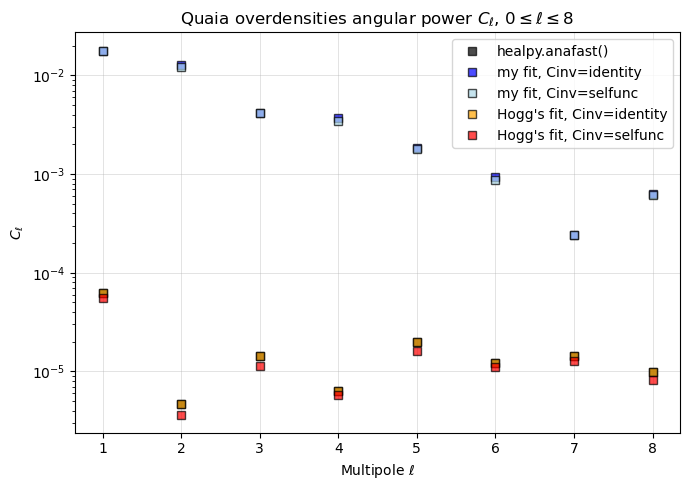

In [27]:
# compare to my own Cells for this max_ell
iell = np.where(max_ells==max_ell)[0][0]

fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
kwargs = dict(marker='s', ls='None', alpha=0.7, mec='k')
ax.plot(ellss[iell][1:], Cells_hp[1:], c='k', label='healpy.anafast()', **kwargs)
ax.plot(ellss[iell][1:], myCells_noweights[1:], c='b', label='my fit, Cinv=identity', **kwargs)
ax.plot(ellss[iell][1:], myCells_selfuncweights[1:], c='lightblue', label='my fit, Cinv=selfunc', **kwargs)
ax.plot(ellss[iell][1:], myCells_Hogg_noweights[1:], c='orange', label='Hogg\'s fit, Cinv=identity', **kwargs)
ax.plot(ellss[iell][1:], myCells_Hogg_sf[1:], c='r', label='Hogg\'s fit, Cinv=selfunc', **kwargs)
ax.semilogy()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$C_\ell$')
ax.set_title(r'Quaia overdensities angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend()

In [28]:
# reconstruct map from Hogg's fit
# ** equally weight all pixels
Cinv_identity = np.ones_like(Cinv)
# indices to fit
map_to_fit, A_fit, Cinv_fit = overdensity_map.copy(), A.copy(), Cinv_identity.copy()
map_to_fit[~idx_to_fit] = 0
Cinv_fit[~idx_to_fit] = 1.0 # totally made up and wrong MAGIC
# perform the regression: bestfit_pars are the alms
almss_Hogg, bestfit_Cinv = tools.lstsq(map_to_fit, A_fit, Cinv_identity)

# iterative over ells to correctly assign the alms to their respective multipoles
reconstructed_map = np.zeros_like(overdensity_map)
ell = 0
i1 = 0  # this will give us the starting index to pull from amps for each ell
while i1 < len(almss_Hogg):
    i2 = i1 + 2 * ell + 1  # stopping index to pull from amps
    assert i2 <= len(almss_Hogg)  # make sure we aren't trying to pull more amplitudes than we input!
    # add the map for this ell to the overall reconstructed map
    map_thisell = np.zeros_like(overdensity_map)
    for im, alm_ in enumerate(almss_Hogg[i1:i2]):
        map_thisell += alm_ * templatess[iell][i1:i2][im]
    reconstructed_map += map_thisell
    ell += 1
    i1 = i2

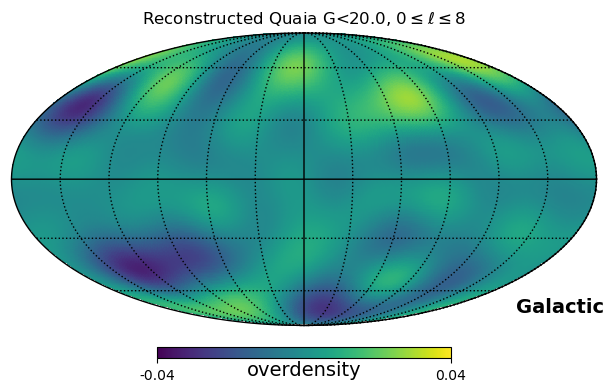

In [29]:
# plot the best-fit model for this max_ell!
fig = plt.figure(figsize=(12,4))
hp.mollview(reconstructed_map, coord=['C','G'], unit='overdensity', min=-.04, max=.04, sub=(1,2,1), fig=fig,
            title=f'Reconstructed Quaia G<{d.maglim}, $0\leq\ell\leq$'f'{max_ell}')
hp.graticule()

In [30]:
# try fitting only up to the octupole
max_ell = 3
iell = np.where(max_ells==max_ell)[0][0]

# construct Ylm templates
ells = np.arange(0, max_ell+1)
templates = construct_templates(ells, NSIDE=NSIDE)

# design matrix: just the templates
A = templates.T

# reconstruct map from Hogg's fit
# ** equally weight all pixels
Cinv_identity = np.ones_like(Cinv)
# indices to fit
map_to_fit, A_fit, Cinv_fit = overdensity_map.copy(), A.copy(), Cinv_identity.copy()
map_to_fit[~idx_to_fit] = 0
Cinv_fit[~idx_to_fit] = 1.0 # totally made up and wrong MAGIC
# perform the regression: bestfit_pars are the alms
almss_Hogg, bestfit_Cinv = tools.lstsq(map_to_fit, A_fit, Cinv_identity)

# iterative over ells to correctly assign the alms to their respective multipoles
reconstructed_map = np.zeros_like(overdensity_map)
ell = 0
i1 = 0  # this will give us the starting index to pull from amps for each ell
while i1 < len(almss_Hogg):
    i2 = i1 + 2 * ell + 1  # stopping index to pull from amps
    assert i2 <= len(almss_Hogg)  # make sure we aren't trying to pull more amplitudes than we input!
    # add the map for this ell to the overall reconstructed map
    map_thisell = np.zeros_like(overdensity_map)
    for im, alm_ in enumerate(almss_Hogg[i1:i2]):
        map_thisell += alm_ * templatess[iell][i1:i2][im]
    reconstructed_map += map_thisell
    ell += 1
    i1 = i2

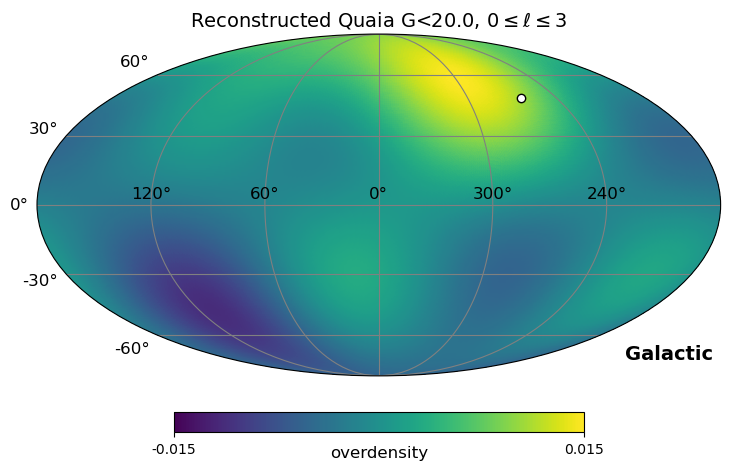

In [35]:
# plot the best-fit model for this max_ell!
fig = plt.figure(figsize=(16,8))
hp.projview(reconstructed_map, coord=['C','G'], unit='overdensity', min=-.015, max=.015, sub=(1,2,1), fig=fig,
            title=f'Reconstructed Quaia G<{d.maglim}, $0\leq\ell\leq$'f'{max_ell}',
            graticule=True, graticule_color='grey', graticule_labels=True)
# also plot cmb dipole!
cmbdipamp, cmbdipdir = dipole.cmb_dipole()
tools.plot_marker(lon=cmbdipdir.galactic.l.deg, lat=cmbdipdir.galactic.b.deg, c='w', marker='o', mec='k', label='CMB')
ax = fig.gca()
tools.label_coord(ax, "Galactic")
# ax.legend()  # this weirdly causes the kernel to die ??

### compare to Giulio's results

In [36]:
res_giulio = np.load(f'/scratch/aew492/quasars/quaia_PS/G{d.maglim}_selfunc50_remove_dipole_True.pkl', allow_pickle=True)

In [37]:
res_giulio['nmt']['diagk_corrg']['data'].keys()

dict_keys([('k', 'k'), ('g_sel', 'g_sel'), ('k', 'g_sel'), ('g1_sel', 'g1_sel'), ('g2_sel', 'g2_sel'), ('g1_sel', 'g2_sel'), ('k', 'gjk_sel'), ('gjk_sel', 'gjk_sel')])

In [38]:
ells_giulio = res_giulio['nmt']['lb']
gg = res_giulio['nmt']['diagk_corrg']['data'][('g_sel','g_sel')]

In [39]:
# current understanding of the "correct" fit: regularize by setting masked pixels to zero; weight by SF

# construct Ylm templates
max_ell = 16
ells = np.arange(0, max_ell+1)
templates = construct_templates(ells, NSIDE=NSIDE)

# design matrix: just the templates
A = templates.T

# ** weight by selection function
Cinv = selfunc

# indices to fit
map_to_fit, A_fit, Cinv_fit = overdensity_map.copy(), A.copy(), Cinv.copy()
map_to_fit[~idx_to_fit] = 0
Cinv_fit[~idx_to_fit] = 1.0 # totally made up and wrong MAGIC
# perform the regression: bestfit_pars are the alms
bestfit_pars, bestfit_Cinv = tools.lstsq(map_to_fit, A_fit, Cinv_fit)
myCells = compute_Cells(bestfit_pars)

In [ ]:
# and no weights
# ** weight by selection function
Cinv = np.identity(len(selfunc))

# indices to fit
map_to_fit, A_fit, Cinv_fit = overdensity_map.copy(), A.copy(), Cinv.copy()
map_to_fit[~idx_to_fit] = 0
Cinv_fit[~idx_to_fit] = 1.0 # totally made up and wrong MAGIC
# perform the regression: bestfit_pars are the alms
bestfit_pars, bestfit_Cinv = tools.lstsq(map_to_fit, A_fit, Cinv_fit)
myCells_noweights = compute_Cells(bestfit_pars)

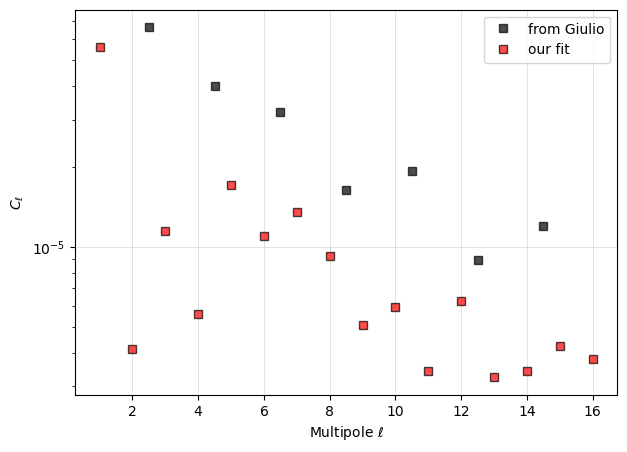

In [33]:
# only look at the low ells
idx = (ells_giulio <= max_ell)
fig, ax = plt.subplots(figsize=(7,5))
kwargs = dict(marker='s', ls='None', alpha=0.7, mec='k')
ax.plot(ells_giulio[idx], gg[idx], c='k', label='from Giulio', **kwargs)
ax.plot(ells[1:], myCells[1:], c='r', label='our fit', **kwargs)
ax.semilogy()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$C_\ell$')
ax.legend()